In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import os

data_dir = './data/dtd/'

images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(images_dir, 'train')
test_dir = os.path.join(images_dir, 'test')
print(train_dir)

./data/dtd/images\train


In [4]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

torch.save(means, "general_means.pt")
torch.save(stds, "general_stds.pt")

Calculated means: tensor([0.5110, 0.4613, 0.4161])
Calculated stds: tensor([0.1683, 0.1691, 0.1660])


In [5]:
means = torch.load("general_means.pt")
stds = torch.load("general_stds.pt")

In [6]:
pretrained_size = 224

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

In [7]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [9]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 29019
Number of validation examples: 3225
Number of testing examples: 1315


In [11]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image  

In [12]:
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [ ]:
plot_images(images, labels, classes, normalize=True)

In [13]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [14]:
def plot_filter(images, filter, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Filtered')
        ax.axis('off')

In [ ]:
N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

In [ ]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

In [15]:
def plot_subsample(images, pool_type, pool_size, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    images = images.permute(0, 2, 3, 1)
    pooled_images = pooled_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Subsampled')
        ax.axis('off')

In [16]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE,
                                 num_workers=8)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE,
                                 num_workers=8)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Defining the Model

In [17]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = [
    'ShuffleNetV2', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0',
    'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0'
]

model_urls = {
    'shufflenetv2_x0.5': 'https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth',
    'shufflenetv2_x1.0': 'https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth',
    'shufflenetv2_x1.5': None,
    'shufflenetv2_x2.0': None,
}


def channel_shuffle(x, groups):
    # type: (torch.Tensor, int) -> torch.Tensor
    batchsize, num_channels, height, width = x.data.size()
    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups,
               channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride):
        super(InvertedResidual, self).__init__()

        if not (1 <= stride <= 3):
            raise ValueError('illegal stride value')
        self.stride = stride

        branch_features = oup // 2
        assert (self.stride != 1) or (inp == branch_features << 1)

        if self.stride > 1:
            self.branch1 = nn.Sequential(
                self.depthwise_conv(inp, inp, kernel_size=3, stride=self.stride, padding=1),
                nn.BatchNorm2d(inp),
                nn.Conv2d(inp, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(branch_features),
                nn.ReLU(inplace=True),
            )
        else:
            self.branch1 = nn.Sequential()

        self.branch2 = nn.Sequential(
            nn.Conv2d(inp if (self.stride > 1) else branch_features,
                      branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
            self.depthwise_conv(branch_features, branch_features, kernel_size=3, stride=self.stride, padding=1),
            nn.BatchNorm2d(branch_features),
            nn.Conv2d(branch_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
        )

    @staticmethod
    def depthwise_conv(i, o, kernel_size, stride=1, padding=0, bias=False):
        return nn.Conv2d(i, o, kernel_size, stride, padding, bias=bias, groups=i)

    def forward(self, x):
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)

        out = channel_shuffle(out, 2)

        return out


class ShuffleNetV2(nn.Module):
    def __init__(self, stages_repeats, stages_out_channels, num_classes=1000, inverted_residual=InvertedResidual):
        super(ShuffleNetV2, self).__init__()

        if len(stages_repeats) != 3:
            raise ValueError('expected stages_repeats as list of 3 positive ints')
        if len(stages_out_channels) != 5:
            raise ValueError('expected stages_out_channels as list of 5 positive ints')
        self._stage_out_channels = stages_out_channels

        input_channels = 3
        output_channels = self._stage_out_channels[0]
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, 2, 1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
        input_channels = output_channels

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        stage_names = ['stage{}'.format(i) for i in [2, 3, 4]]
        for name, repeats, output_channels in zip(
                stage_names, stages_repeats, self._stage_out_channels[1:]):
            seq = [inverted_residual(input_channels, output_channels, 2)]
            for i in range(repeats - 1):
                seq.append(inverted_residual(output_channels, output_channels, 1))
            setattr(self, name, nn.Sequential(*seq))
            input_channels = output_channels

        output_channels = self._stage_out_channels[-1]
        self.conv5 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Linear(output_channels, num_classes)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = x.mean([2, 3])  # globalpool
        x = self.fc(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)


def _shufflenetv2(arch, pretrained, progress, *args, **kwargs):
    model = ShuffleNetV2(*args, **kwargs)

    if pretrained:
        model_url = model_urls[arch]
        if model_url is None:
            raise NotImplementedError('pretrained {} is not supported as of now'.format(arch))
        else:
            state_dict = load_state_dict_from_url(model_url, progress=progress)
            model.load_state_dict(state_dict)

    return model


def shufflenet_v2_x0_5(pretrained=False, progress=True, **kwargs):
    """
    Constructs a ShuffleNetV2 with 0.5x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _shufflenetv2('shufflenetv2_x0.5', pretrained, progress,
                         [4, 8, 4], [24, 48, 96, 192, 1024], **kwargs)


def shufflenet_v2_x1_0(pretrained=False, progress=True, **kwargs):
    """
    Constructs a ShuffleNetV2 with 1.0x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _shufflenetv2('shufflenetv2_x1.0', pretrained, progress,
                         [4, 8, 4], [24, 116, 232, 464, 1024], **kwargs)


def shufflenet_v2_x1_5(pretrained=False, progress=True, **kwargs):
    """
    Constructs a ShuffleNetV2 with 1.5x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _shufflenetv2('shufflenetv2_x1.5', pretrained, progress,
                         [4, 8, 4], [24, 176, 352, 704, 1024], **kwargs)


def shufflenet_v2_x2_0(pretrained=False, progress=True, **kwargs):
    """
    Constructs a ShuffleNetV2 with 2.0x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _shufflenetv2('shufflenetv2_x2.0', pretrained, progress,
                         [4, 8, 4], [24, 244, 488, 976, 2048], **kwargs)


In [18]:
model = shufflenet_v2_x1_0()

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,278,604 trainable parameters


## Training the Model

In [21]:
pretrained_model = models.shufflenet_v2_x1_0(pretrained=True)

In [22]:
print(pretrained_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [23]:
OUTPUT_DIM = len(test_data.classes)

fc_modified = nn.Linear(in_features=pretrained_model.fc.in_features, out_features=OUTPUT_DIM)

pretrained_model.fc = fc_modified
model.fc = fc_modified

We apply the initialization by using the model's `apply` method. This will call the given function on every module and sub-module within the model.

In [24]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

#### LR-Finder

In [25]:
from __future__ import print_function, with_statement, division
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean): if this flag is set to True, `state_dict` of model and
            optimizer will be cached in memory. Otherwise, they will be saved to files
            under the `cache_dir`.
        cache_dir (string): path for storing temporary files. If no path is specified,
            system-wide temporary directory is used.
            Notice that this parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store('model', self.model.state_dict())
        self.state_cacher.store('optimizer', self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""
        self.model.load_state_dict(self.state_cacher.retrieve('model'))
        self.optimizer.load_state_dict(self.state_cacher.retrieve('optimizer'))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
        """
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iterator = iter(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Get a new set of inputs and labels
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, labels = next(iterator)

            # Train on batch and retrieve loss
            loss = self._train_batch(inputs, labels)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")
        return self.history

    def _train_batch(self, inputs, labels):
        # Set model to training mode
        self.model.train()

        # Move data to the correct device
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)

        # Forward pass
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move data to the correct device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Plot loss as a function of the learning rate
        plt.plot(lrs, losses)
        if log_lr:
            plt.xscale("log")
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.show()


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile
            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError('Given `cache_dir` is not a valid directory.')

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, 'state_{}_{}.pt'.format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError('Target {} was not cached.'.format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError('Failed to load state in {}. File does not exist anymore.'.format(fn))
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""
        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])


In [26]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

 97%|█████████▋| 97/100 [16:40<00:30, 10.31s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


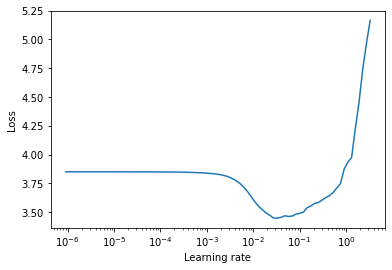

In [27]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(train_loader=train_iterator, end_lr=END_LR, num_iter=NUM_ITER)
lr_finder.plot()

In [28]:
history = lr_finder.history
print(history['lr'][history['loss'].index(min(history['loss']))])

0.027542287033381692


In [29]:
FOUND_LR = 0.027

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

In [30]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [31]:
def calculate_accuracy(y_pred, y):
    # top_pred = y_pred.argmax(1, keepdim=True)
    # correct = top_pred.eq(y.view_as(top_pred)).sum()
    # acc = correct.float() / y.shape[0]
    # predict = y_pred.data.max(1)[1]
    # correct = predict.eq(y.data).cpu().sum(）
    # acc = correct.float() / y.shape[0]
    with torch.no_grad():
        _, predict = y_pred.max(1)
        correct = (predict == y).cpu().sum()
        num_samples = y.size(0)
        acc = float(correct) / float(num_samples) * 100
    return acc

In [32]:
def calculate_topk_accuracy(y_pred, y, topk=(1, )):
    maxk = max(topk)
    batch_size = y.size(0)

    _, top_pred = y_pred.topk(maxk, 1, True, True)
    top_pred = top_pred.t()
    correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
    
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    
    return res

In [33]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = AverageMeter()
    epoch_acc_1 = AverageMeter()
    epoch_acc_5 = AverageMeter()
    
    model.train()
    
    for batch_idx, (x, y) in enumerate(iterator):
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred.data, y.data, topk=(1, 5))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.update(loss.item(), x.size(0))
        epoch_acc_1.update(acc_1.item(), x.size(0))
        epoch_acc_5.update(acc_5.item(), x.size(0))
        
    return float('{loss.avg:.4f}'.format(loss=epoch_loss)), float('{acc_1.avg:.4f}'.format(acc_1=epoch_acc_1)), float('{acc_5.avg:.4f}'.format(acc_5=epoch_acc_5))

In [34]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = AverageMeter()
    epoch_acc_1 = AverageMeter()
    epoch_acc_5 = AverageMeter()
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(iterator):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred.data, y.data, topk=(1, 5))

            epoch_loss.update(loss.data.item(), x.size(0))
            epoch_acc_1.update(acc_1.item(), x.size(0))
            epoch_acc_5.update(acc_5.item(), x.size(0))
            
    return float('{loss.avg:.4f}'.format(loss=epoch_loss)), float('{acc_1.avg:.4f}'.format(acc_1=epoch_acc_1)), float('{acc_5.avg:.4f}'.format(acc_5=epoch_acc_5))

In [35]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5:6.2f}%')

Epoch: 01 | Epoch Time: 20m 23s
	Train Loss: 33.293 | Train Acc @1:   2.15% | Train Acc @5:  11.21%
	Valid Loss: 1108285898218.219 | Valid Acc @1:   2.11% | Valid Acc @5:  11.97%
Epoch: 02 | Epoch Time: 20m 35s
	Train Loss: 7.419 | Train Acc @1:   2.44% | Train Acc @5:  11.40%
	Valid Loss: 1930669831684.355 | Valid Acc @1:   3.07% | Valid Acc @5:  12.03%


KeyboardInterrupt: 

We then load the parameters of our model that achieved the best validation loss and evaluate this model on the test set to achieve a ~75% accuracy.

In [33]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1:6.2f}% | Test Acc @5: {test_acc_5:6.2f}%')

Test Loss: 2.590 | Test Acc @1:  39.77% | Test Acc @5:  73.76%


### Examining the Model

We will do the exact same probing into our model as we did in the previous notebooks: plotting a confusion matrix, plotting the most confident incorrect predictions, using PCA and t-SNE, and viewing the learned weights of our model.

First, we'll collect all the predictions.

In [34]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [35]:
images, labels, probs = get_predictions(model, test_iterator, device)

Then, for each prediction we get the predicted class.

In [36]:
pred_labels = torch.argmax(probs, 1)

Next, we plot the confusion matrix. This time we have edited the function to allow us to pass a list of strings which are the labels classes.

In [37]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(50, 50))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=90)

The two classes our model seems to get mixed up the most is cat and dog.

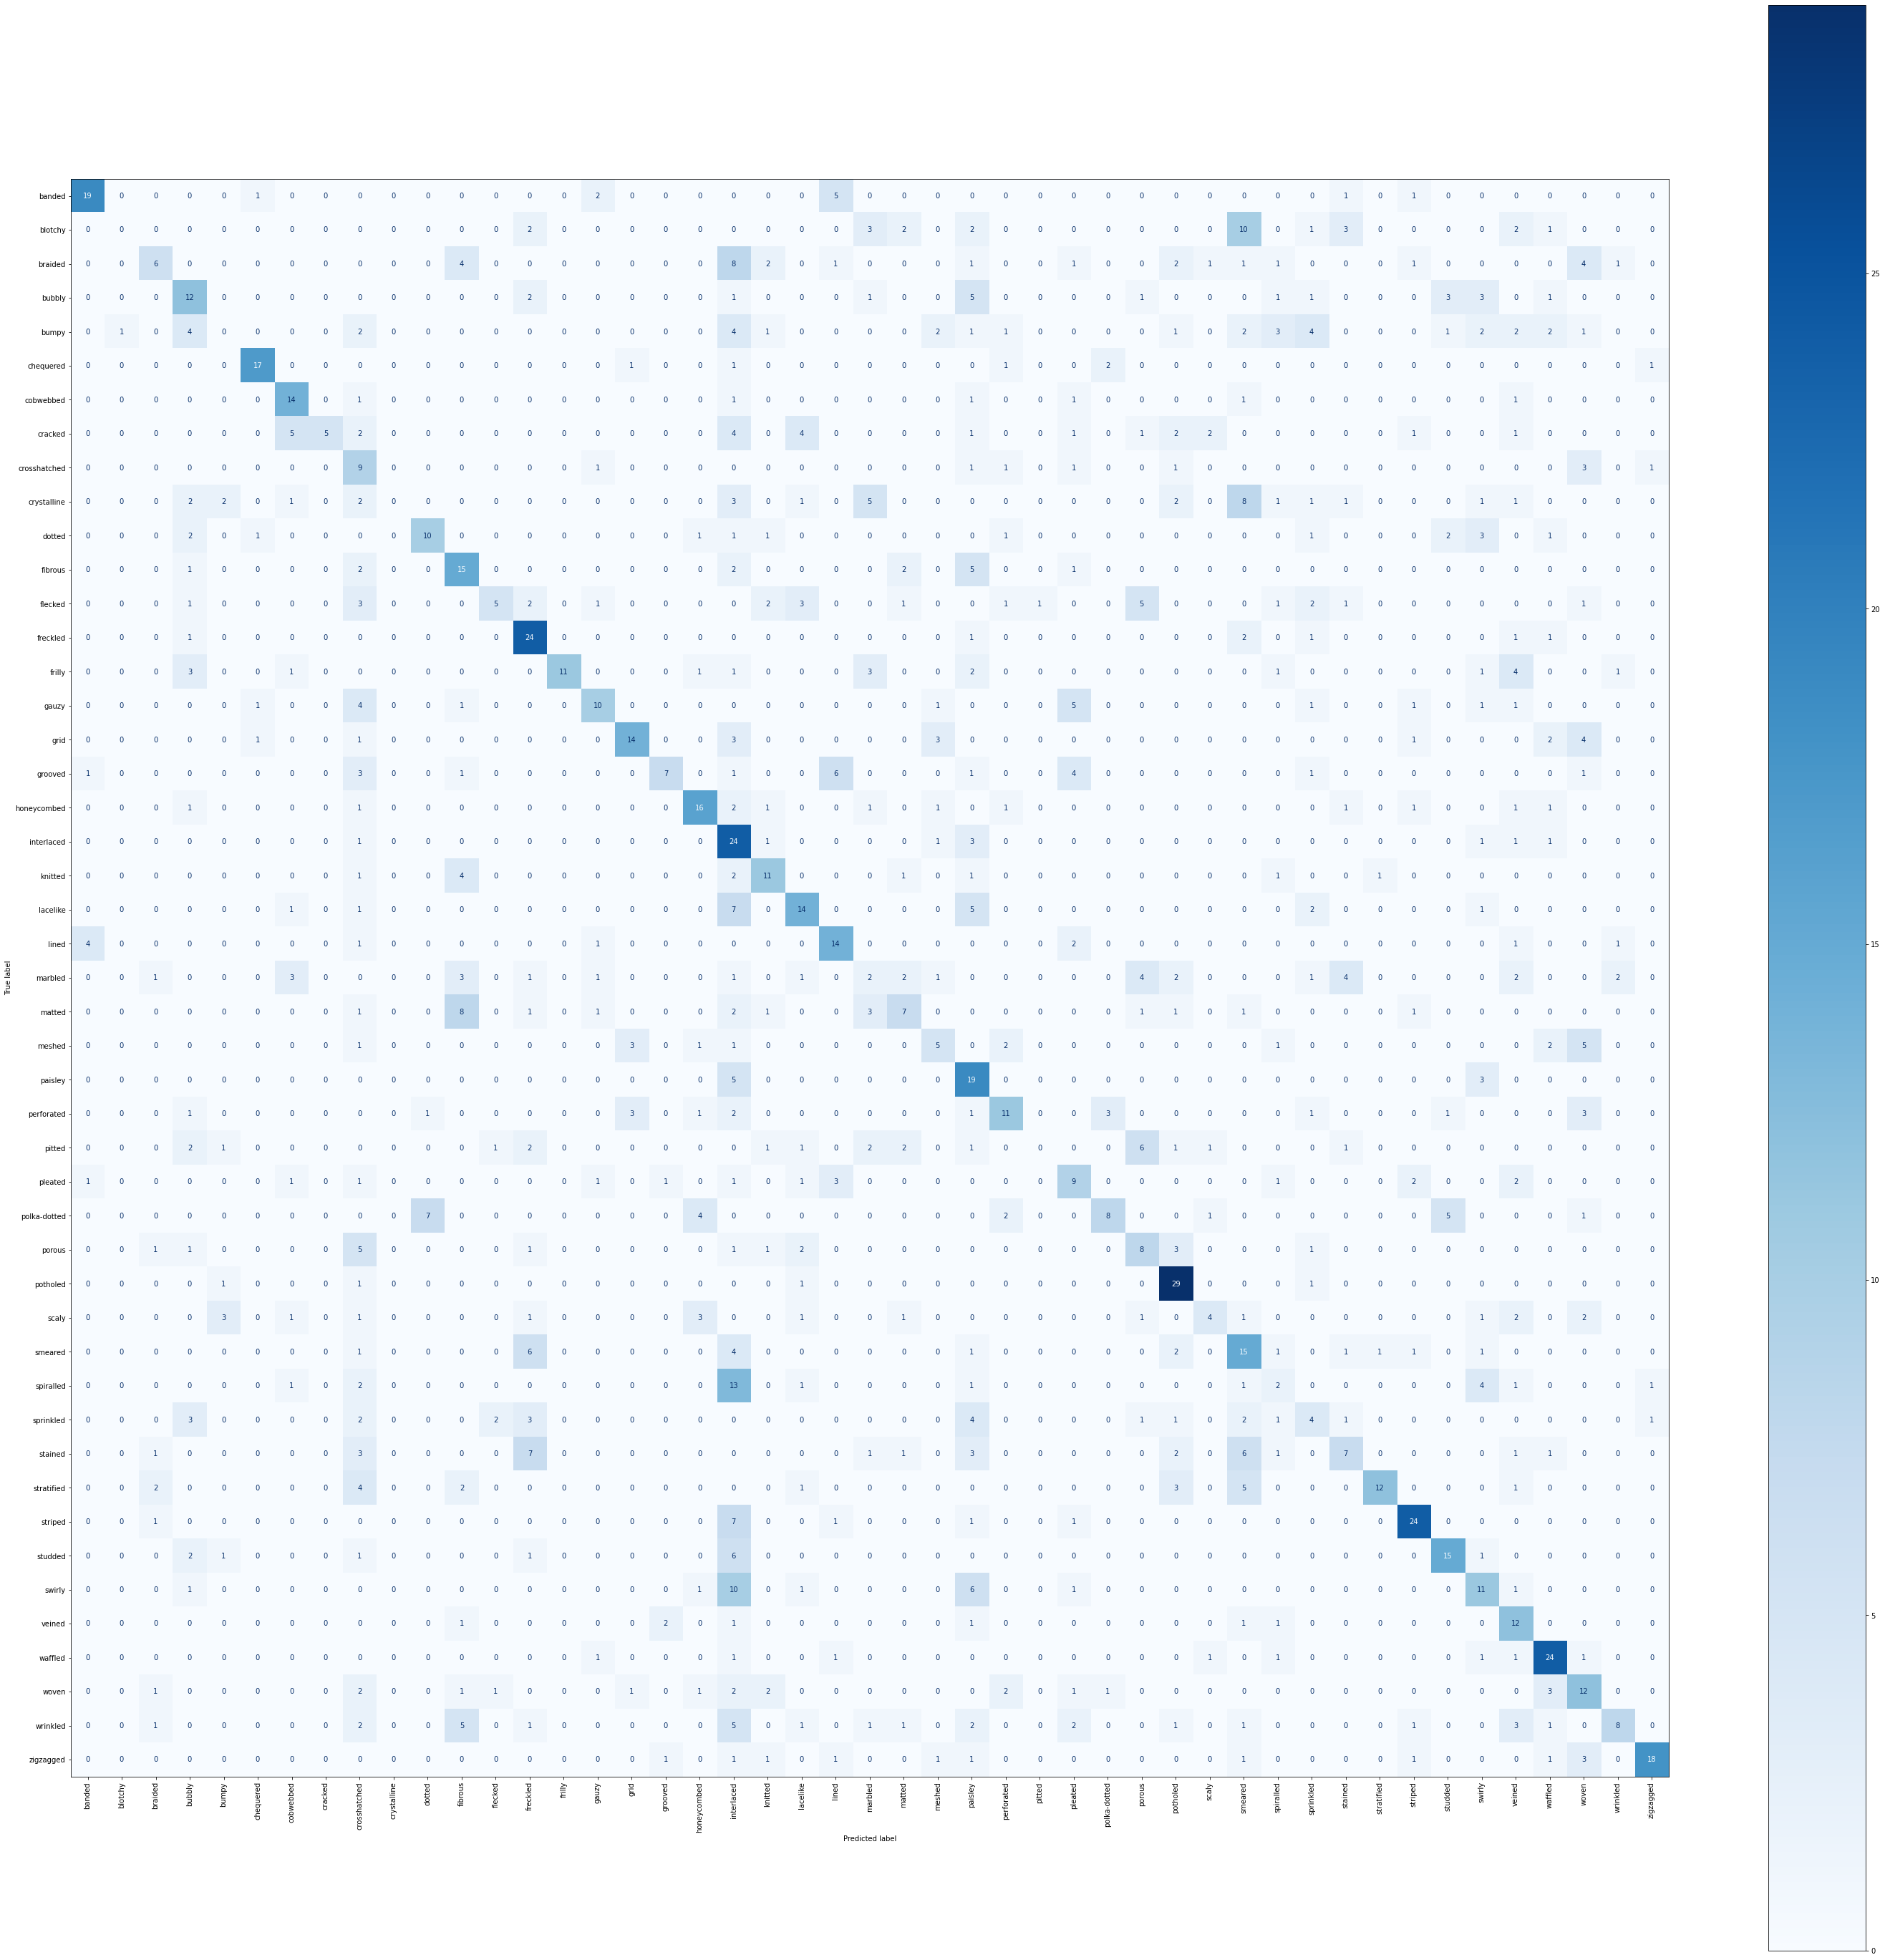

In [38]:
plot_confusion_matrix(labels, pred_labels, train_data.dataset.classes)

We can then find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [39]:
corrects = torch.eq(labels, pred_labels)

In [40]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [41]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

Interestingly, the most incorrect was an example that is incorrectly labelled in the dataset itself. It is clearly a frog, which our model predicted with 100% confidence, but the label is cat.

Truck and automobile seem to be confused a lot but even to humans these two classes are slightly ambiguous.

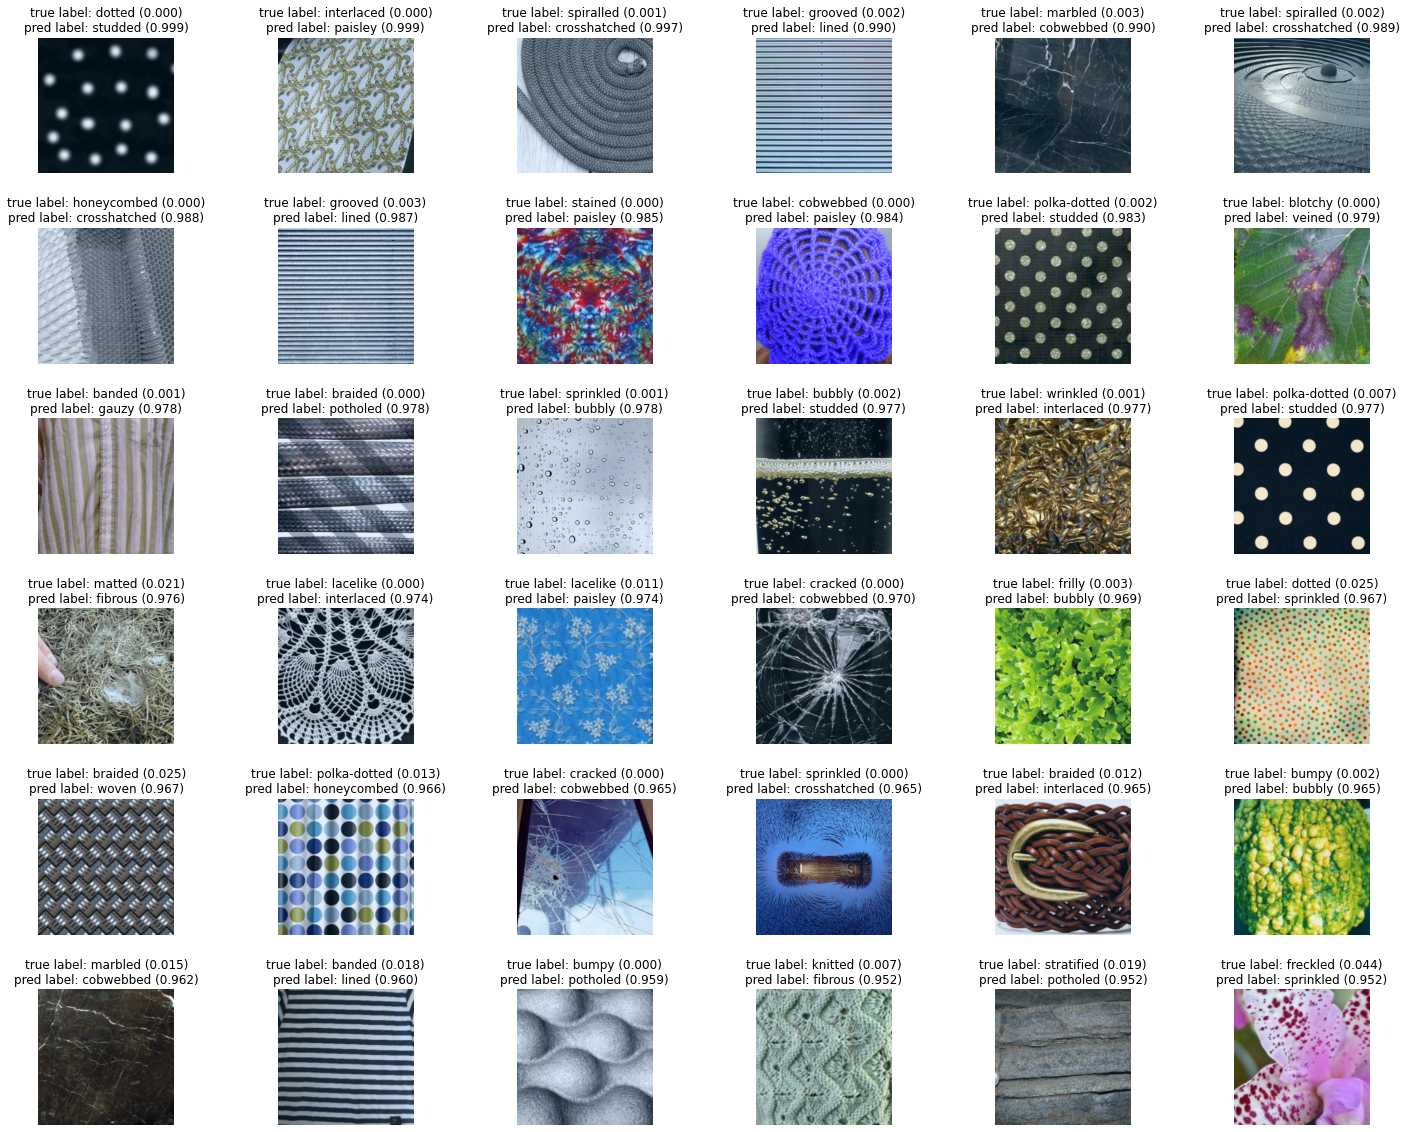

In [45]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, test_iterator.dataset.classes, N_IMAGES)

Next, we'll get the output and intermediate (after the flatten) representations.

In [46]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(y.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [47]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/16 [00:00<?, ?it/s]

We can then perform PCA on them both and plot them.

In [48]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [49]:
def plot_representations(data, labels, classes, n_images=None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

Like previous notebooks, the classes seem more separated in the output representations than the intermediate representations.

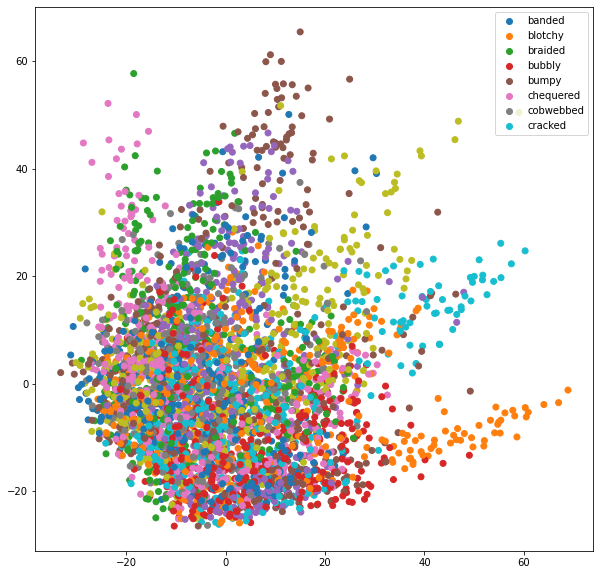

In [51]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, test_iterator.dataset.classes)

In [52]:
intermediate_pca_data = get_pca(intermediates.reshape(-1, 1))
plot_representations(intermediate_pca_data, labels, classes)

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

We can do the same with the t-SNE algorithm. 

Again, we only use a subset of the data as t-SNE takes a considerable amount of time to compute.

We also see that the classes are more well separated in the output representations compared to the intermediate representations.

In [53]:
def get_tsne(data, n_components=2, n_images=None):

    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


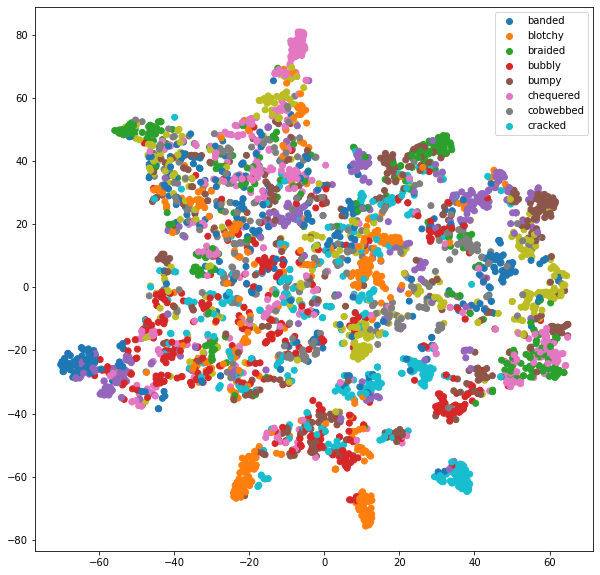

In [55]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, test_iterator.dataset.classes, n_images=N_IMAGES)

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images=N_IMAGES)

We can also imagine an image belonging to a specified class. 

Spoilers: this didn't work in the previous notebooks, won't work here, and won't work in the future. This is the last time we'll attempt to generate an image.

If you do know a simple method to generate images that look better than pure random noise, feel free to [submit an issue](https://github.com/bentrevett/pytorch-image-classification/issues) on how it is done and it can be added to these tutorials.

In [ ]:
def imagine_image(model, classes, image, device, n_iterations=10_000):

    model.eval()

    label = classes.index(image)

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(256, 3, 32, 32).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, label], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [ ]:
IMAGE = 'frog'

best_image, best_prob = imagine_image(model, classes, IMAGE, device)

We get an image that our model is ~100% confident is a frog, but just looks like random noise.

In [ ]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

In [ ]:
best_image = normalize_image(best_image)

plt.imshow(best_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off');

Next, we'll plot some images after they have been convolved with the first convolutional layer.

In [ ]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

We can see different types of edge detection and blurring that the filters have learned that are apparently decent feature extractors for this model and task.

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the actual filters our model has learned.

In [ ]:
def plot_filters(filters, normalize=True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize=(20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace=-0.9)

Again, nothing really interpretable here, sadly.

In [ ]:
plot_filters(filters)

Can we ever learn interesting looking filters? Or are we doomed to just look at colorful blocks forever?

Well, we can take a *pre-trained* AlexNet model and view the filters of that. This pre-trained version of AlexNet was trained by people at PyTorch and was not trained on the CIFAR10 dataset, but on the [ILSVRC](https://arxiv.org/abs/1409.0575) dataset, usually just called the ImageNet dataset. ImageNet is a dataset with over 1 million images in 1,000 classes. Torchvision provides ways of downloading different models pre-trained on ImageNet, such as AlexNet and [many others](https://pytorch.org/vision/stable/models.html).  

First, we can import the model making sure to pass `pretrained = True` to get a pre-trained version. Torchvision will then import the model, download the weights for it and load them into the new model.

We can see that this is similar to our AlexNet model but has considerably more parameters.

One interesting thing is that they use much larger filters in the first convolutional layer - 11x11 instead of 3x3.

In [ ]:
model = models.alexnet(pretrained=True)

print(model)

We can then get the learned values of these filters the same way we did for our version of AlexNet and then plot them.

As we can see the patterns are much more interesting, though still not really interpretable.

So how come it learned these interesting looking filters? Is it just because the filters are bigger? Is it because models can only do well on ImageNet if they learn more interesting filters? Or something else?

Do more interesting looking filters imply that they perform better? Or are these filters showing how the model has overfit to patterns on the images within ImageNet?

It is difficult to answer these questions as modern computer vision architectures now seem to favour smaller filter sizes with their largest filters being 5x5 - so maybe larger filters aren't that good after all?

In [ ]:
filters = model.features[0].weight.data

plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (AlexNet)
- custom weight initialization
- how to use the learning rate finder
- training a model to achieve >75% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- generating fake images
- viewing the learned weights of our model
- loading a pre-trained model

In the next notebook we'll implement a popular CNN architecture, VGG, and learn about how to actually use pre-trained models on our dataset.